In [725]:
# Import all the necessary libraries for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
import datetime
# plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# For the machine learning model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
# Misc
import missingno as msno

In [726]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install imblearn
# !pip install seaborn
# !pip install plotly
# !pip install scikit-learn
# !pip install missingno

In [727]:
# # get out the current directory
# current_dir = os.getcwd()
# # get out the parent directory
# parent_dir = os.path.dirname(cuuser_dfrrent_dir)
# # change to the parent directory
# os.chdir(parent_dir)

In [728]:
path = "../inter-uni-datathon-2024-nsw/"
train_df = pd.read_csv(path + "train.csv")
test_df = pd.read_csv(path + "test.csv")

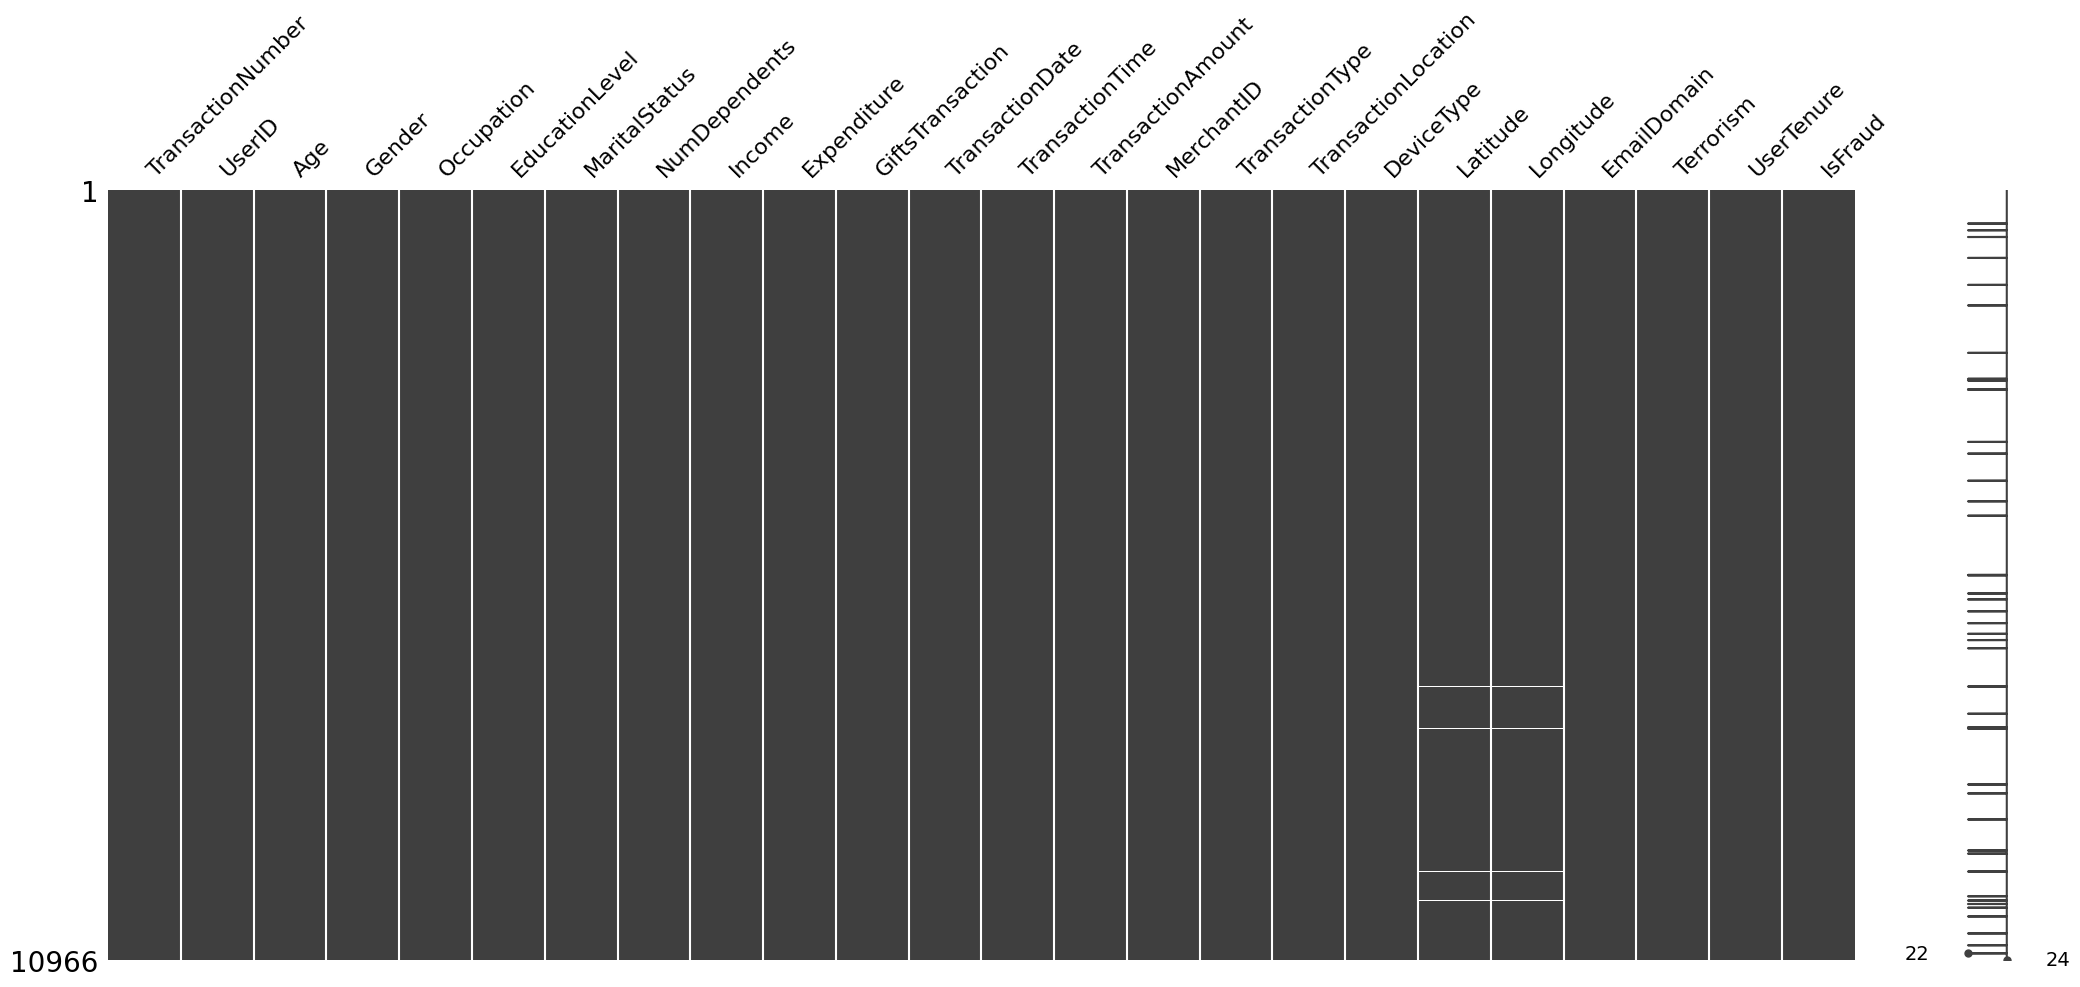

<Figure size 1500x900 with 0 Axes>

In [729]:
# Missing data
msno.matrix(train_df)
plt.figure(figsize = (15,9))
plt.show()

In [730]:
def get_numerical_summary(df):
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent

missing_percent = get_numerical_summary(train_df)
missing_percent

Latitude : 43 (0.392%)
Longitude : 43 (0.392%)


{'Latitude': np.float64(0.3921211015867226),
 'Longitude': np.float64(0.3921211015867226)}

In [731]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='majority')
X_rus, y_rus = rus.fit_resample(train_df.drop(columns=['IsFraud']), train_df['IsFraud'])
train_df = pd.concat([X_rus, y_rus], axis=1)

In [732]:
# Age (does young adult cause more fraud?)
user_info = [
    "Age", 
    "Gender",
    "Terrorism",
    "Income",
    "MaritalStatus",
    "Occupation",
    "EducationLevel",
    "NumDependents",
    "GiftsTransaction" 
]
transaction_info = [
    "TransactionType", 
    "TransactionDate",
    "TransactionTime", 
    "TransactionAmount",
    "TransactionLocation",
    "MerchantID",
    "DeviceType"
]
account_info = [
    "UserTenure",
    "Expenditure",
    "Latitude",
    "Longitude",
    "EmailDomain"
]

## Cleaning

### Datetime

In [733]:
def standard_time(time_str):
    try:
        if 'AM' in time_str or 'PM' in time_str:
            return pd.to_datetime(time_str, format='%I:%M:%S %p').strftime('%H:%M:%S')
        
        return pd.to_datetime(time_str, format='%H:%M:%S').strftime('%H:%M:%S')
    
    except (ValueError, TypeError):
        try:
            parts = time_str.split('/')
            corrected_time = f'{parts[0]}:{parts[1]}:{parts[2]}'
            return pd.to_datetime(corrected_time, format='%H:%M:%S').strftime('%H:%M:%S')
        except Exception:
            return 'NOPES'

def categorize_time(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

train_df['TransactionTime'] = train_df['TransactionTime'].apply(standard_time)
# apply categorize_time function to TransactionTime column
train_df['TransactionTime'] = pd.to_datetime(train_df['TransactionTime'], format='%H:%M:%S').dt.hour
train_df['TransactionTime'] = train_df['TransactionTime'].apply(categorize_time)

train_df['TransactionDate'] = pd.to_datetime(train_df['TransactionDate'], dayfirst=True)

train_df['date'] = train_df['TransactionDate'].dt.day   
train_df['Month'] = train_df['TransactionDate'].dt.month  

train_df['weekday'] = train_df['TransactionDate'].dt.day_name()

/tmp/ipykernel_40899/909910050.py:31: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  train_df['TransactionDate'] = pd.to_datetime(train_df['TransactionDate'], dayfirst=True)


In [734]:
# gimme categorical columns
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7990 entries, 3387 to 10965
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   TransactionNumber    7990 non-null   int64         
 1   UserID               7990 non-null   int64         
 2   Age                  7990 non-null   int64         
 3   Gender               7990 non-null   object        
 4   Occupation           7990 non-null   object        
 5   EducationLevel       7990 non-null   object        
 6   MaritalStatus        7990 non-null   object        
 7   NumDependents        7990 non-null   int64         
 8   Income               7990 non-null   object        
 9   Expenditure          7990 non-null   object        
 10  GiftsTransaction     7990 non-null   object        
 11  TransactionDate      7990 non-null   datetime64[ns]
 12  TransactionTime      7990 non-null   object        
 13  TransactionAmount    7990 non-null

### Drop irrelevant columns

In [735]:
# Keep only the columns above
train_df = train_df[user_info + transaction_info + account_info + ['IsFraud']]

### Clean currency data (4 columns)

In [736]:
import re
import pandas as pd

def get_currency_and_symbol(val):
    if 'AUD' in val or 'AU' in val:
        # create a feature for aud
        return re.sub(r'[^\d.]', '', val), 'AUD' 
    elif 'AED' in val:
        value = re.sub(r'[^\d.]', '', val)
        # convert AED to AUD
        return float(value) * 0.35, 'AED'
    elif '£' in val:
        value = re.sub(r'[^\d.]', '', val)
        # convert pounds to AUD
        return float(value) * 1.8, 'GBP'
    elif 'GBP' in val:
        value = re.sub(r'[^\d.]', '', val)
        # convert pounds to AUD
        return float(value) * 1.8, 'GBP'
    else:
        return "Unidentified", "Unknown" 


# Apply to Income
train_df['Income'], train_df['Income_Currency'] = zip(*train_df['Income'].apply(get_currency_and_symbol))
train_df['Income'] = pd.to_numeric(train_df['Income'], errors='coerce')  

# Apply to Expenditure
train_df['Expenditure'], train_df['Expenditure_Currency'] = zip(*train_df['Expenditure'].apply(get_currency_and_symbol))
train_df['Expenditure'] = pd.to_numeric(train_df['Expenditure'], errors='coerce')

# Apply to GiftsTransaction
train_df['GiftsTransaction'], train_df['GiftsTransaction_Currency'] = zip(*train_df['GiftsTransaction'].apply(get_currency_and_symbol))
train_df['GiftsTransaction'] = pd.to_numeric(train_df['GiftsTransaction'], errors='coerce')

# Apply to TransactionAmount
train_df['TransactionAmount'], train_df['TransactionAmount_Currency'] = zip(*train_df['TransactionAmount'].apply(get_currency_and_symbol))
train_df['TransactionAmount'] = pd.to_numeric(train_df['TransactionAmount'], errors='coerce') 

### Separte data into 3 groups for faster computation/Quick correlation analysis

In [737]:
# Convert categorical data to numerical data through One Hot Encoding
user_df = pd.get_dummies(train_df[user_info])
transaction_df = pd.get_dummies(train_df[transaction_info])
account_df = pd.get_dummies(train_df[account_info])
# Append IsFraud to the all dfs
user_df['IsFraud'] = train_df['IsFraud']
transaction_df['IsFraud'] = train_df['IsFraud']
account_df['IsFraud'] = train_df['IsFraud']

In [738]:
# Calculate correlations once for each DataFrame
user_corr = user_df.corrwith(user_df['IsFraud'])
transaction_corr = transaction_df.corrwith(transaction_df['IsFraud'])
account_corr = account_df.corrwith(account_df['IsFraud'])

# Sort the correlations in descending order
user_corr = user_corr.sort_values(ascending=False)
transaction_corr = transaction_corr.sort_values(ascending=False)
account_corr = account_corr.sort_values(ascending=False)


In [739]:
user_corr.head(10)

IsFraud                   1.000000
MaritalStatus_Divorced    0.035106
EducationLevel_PhD        0.022987
Gender_he                 0.014147
Occupation_Unemployed     0.013361
Income                    0.013334
GiftsTransaction          0.011673
Gender_woman              0.009221
Terrorism                 0.008123
MaritalStatus_Widowed     0.007941
dtype: float64

In [740]:
transaction_corr.head(10)

IsFraud                         1.000000
TransactionTime_Night           0.632750
TransactionType_Withdrawal      0.529883
TransactionAmount               0.105043
TransactionLocation_Brisbane    0.048982
TransactionLocation_Hobart      0.035493
TransactionLocation_Perth       0.033604
TransactionLocation_Adelaide    0.031451
TransactionLocation_Darwin      0.031194
TransactionLocation_Sydney      0.029868
dtype: float64

In [741]:
account_corr

IsFraud                                  1.000000
EmailDomain_smithsamantha@outlook.com    0.031658
EmailDomain_vthomas@gmail.com            0.031658
EmailDomain_marvin60@gmail.com           0.029612
EmailDomain_nwright@yahoo.com            0.029612
                                           ...   
EmailDomain_ebruce@gmail.com            -0.025023
EmailDomain_costatimothy@gmail.com      -0.025023
EmailDomain_lsmith@gmail.com            -0.027414
EmailDomain_jonesryan@outlook.com       -0.027414
EmailDomain_jharris@gmail.com           -0.031658
Length: 3906, dtype: float64

### Clean email domain

In [742]:
# Keep only the domain after @ for EmailDomain
train_df['EmailDomain'] = train_df['EmailDomain'].apply(lambda x: x.split('@')[1])

### Categorical columns

In [743]:
gender_mapping = {
    'fem': 'Female',
    'Female': 'Female',
    'she': 'Female',
    'woman': 'Female',
    'he': 'Male',
    'man': 'Male',
    'Male': 'Male',
    'isnotfemale': 'Male',
    'isnotmale': 'Female',
}

train_df['Gender'] =train_df['Gender'].map(gender_mapping).fillna('Other')

## EDA

In [744]:
# make default plot smaller
plt.rcParams['figure.figsize'] = [12, 3]

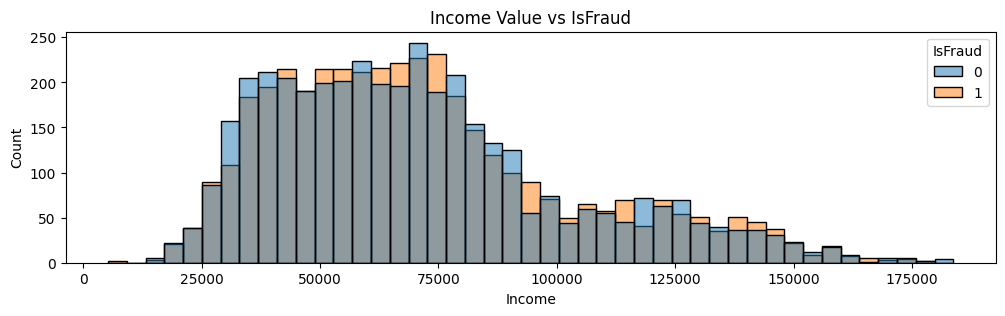

In [745]:
# Plot the income against the isFraud, histogram
sns.histplot(x='Income', hue='IsFraud', data=train_df)
plt.title('Income Value vs IsFraud')
plt.show()

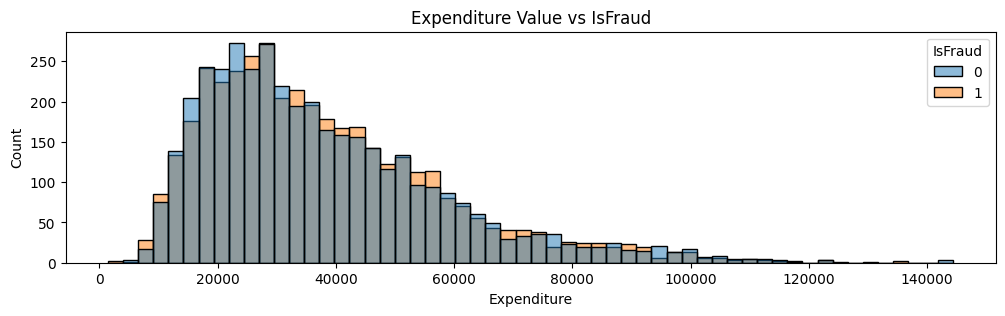

In [746]:
# Plot expenditure value against the isFraud, histogram
sns.histplot(x='Expenditure', hue='IsFraud', data=train_df)
plt.title('Expenditure Value vs IsFraud')
plt.show()

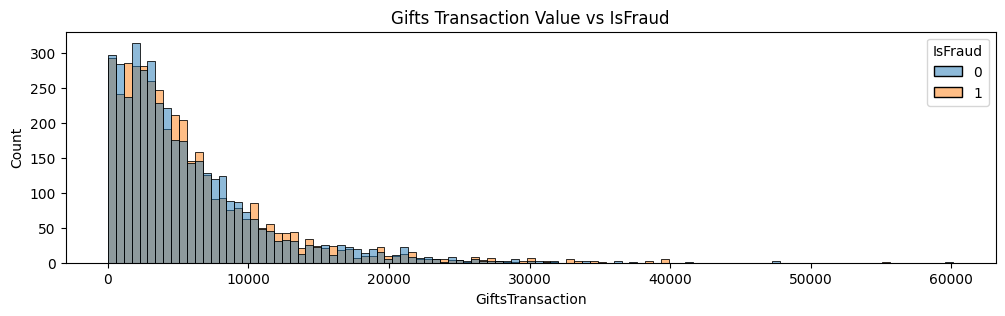

In [747]:
# Plot gifts transaction value against the isFraud, histogram
sns.histplot(x='GiftsTransaction', hue='IsFraud', data=train_df)
plt.title('Gifts Transaction Value vs IsFraud')
plt.show()

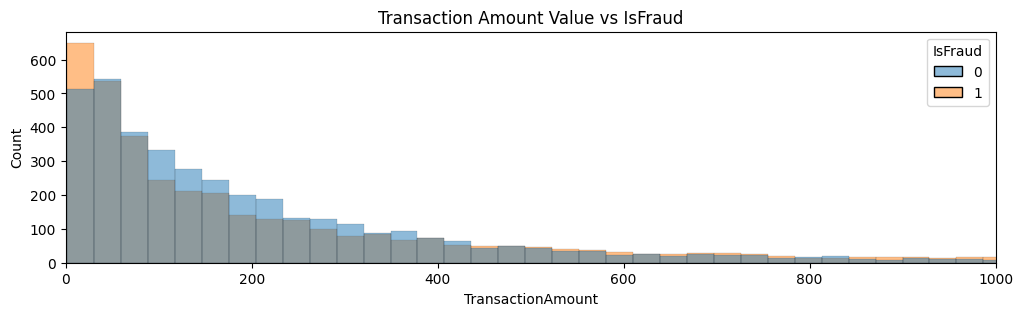

In [748]:
# Plot transaction amount value against the isFraud, histogram, zoom into the range of 0 to 1000
sns.histplot(x='TransactionAmount', hue='IsFraud', data=train_df)
plt.xlim(0, 1000)
plt.title('Transaction Amount Value vs IsFraud')
plt.show()

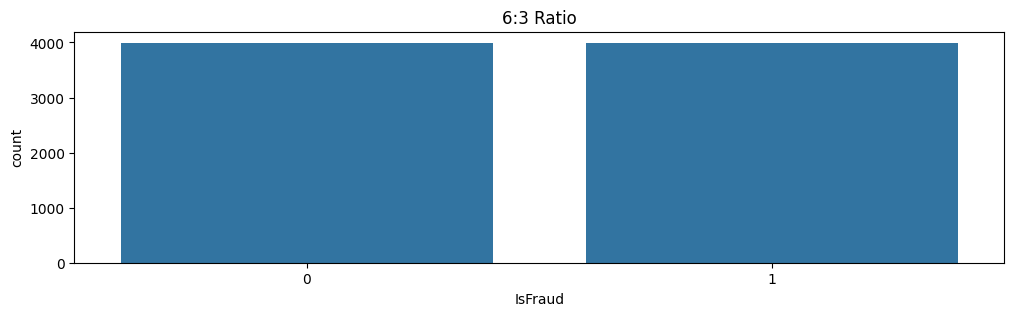

In [749]:
# Check the number of 0 and 1 in the IsFraud column, gimme ratio
train_df['IsFraud'].value_counts(normalize=True)
# Barplot it
sns.countplot(x='IsFraud', data=train_df)
plt.title('6:3 Ratio')
plt.show()

In [750]:
# Check correlation between the features: Income, Expenditure, GiftsTransaction, TransactionAmount, and IsFraud
train_df[['Income', 'Expenditure', 'GiftsTransaction', 'TransactionAmount', 'IsFraud']].corr()

,Income,Expenditure,GiftsTransaction,TransactionAmount,IsFraud
Income,1.000000,0.828307,0.426505,0.006017,0.013334
Expenditure,0.828307,1.000000,0.343762,0.002305,0.001538
GiftsTransaction,0.426505,0.343762,1.000000,-0.008023,0.011673
TransactionAmount,0.006017,0.002305,-0.008023,1.000000,0.105043
IsFraud,0.013334,0.001538,0.011673,0.105043,1.000000


=> Transaction amount, expenditure, and gift transaction values have little correlation with IsFraud

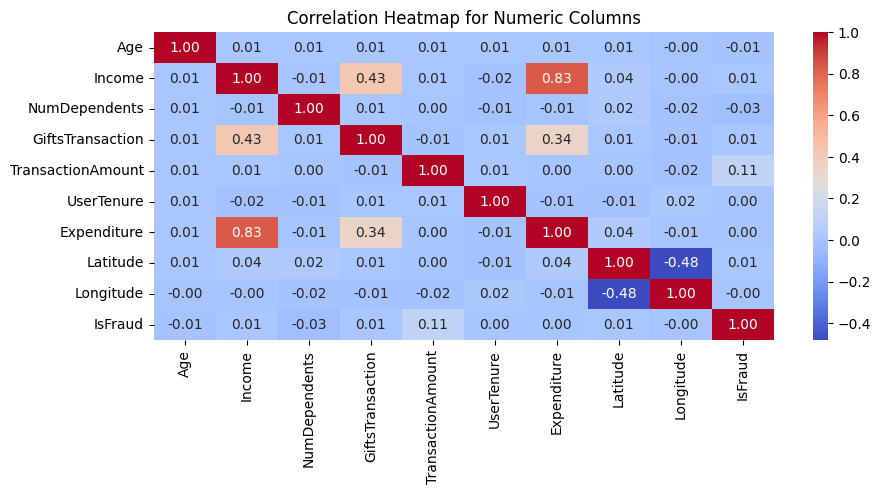

In [751]:
# Select only the numeric columns
numeric_data = train_df.select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric columns
correlation_matrix = numeric_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Numeric Columns')

plt.show()

## Encoding

In [752]:
def binary_encode(df, column, positive_value):
    df = df.copy()
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

def ordinal_encode(df, column, ordering):
    df = df.copy()
    df[column] = df[column].apply(lambda x: ordering.index(x))
    return df


In [753]:
occupation_order = [
    "Student",
    "Unemployed",
   "Retired", 
    "Professional",
]
education_order = [
    "High School","Bachelor","Master","PhD"
]

In [754]:
train_df = binary_encode(train_df, "Gender", "Male")
train_df = ordinal_encode(train_df, "Occupation", occupation_order)
train_df = ordinal_encode(train_df, "EducationLevel", education_order)
train_df = binary_encode(train_df, "Terrorism", True)

In [755]:
# One hot encoding for the rest
train_df = pd.get_dummies(train_df, columns=["MaritalStatus", "TransactionType", "TransactionLocation"])

In [756]:
columns_to_encode = ["Income_Currency", "Expenditure_Currency", "GiftsTransaction_Currency", "TransactionAmount_Currency", "TransactionTime","DeviceType", "MerchantID", "EmailDomain"]
train_df = pd.get_dummies(train_df, columns=columns_to_encode, prefix=columns_to_encode)

In [757]:
# get object column
train_df.select_dtypes(include=['object']).columns.tolist() 


[]

In [758]:
train_df

,Age,Gender,Terrorism,Income,Occupation,EducationLevel,NumDependents,GiftsTransaction,TransactionDate,TransactionAmount,...,MerchantID_M005,MerchantID_M006,MerchantID_M007,MerchantID_M008,EmailDomain_disposable.com,EmailDomain_gmail.com,EmailDomain_outlook.com,EmailDomain_securemail.com,EmailDomain_tempmail.com,EmailDomain_yahoo.com
3387,27,0,1,84965.02,3,1,1,5852.040,2023-12-29,206.8395,...,False,True,False,False,False,True,False,False,False,False
942,18,0,0,161040.14,0,1,3,27686.304,2023-11-17,106.6400,...,False,True,False,False,False,False,False,False,False,True
1508,40,1,0,72181.85,0,0,1,741.330,2023-02-18,148.7600,...,False,False,False,True,False,False,True,False,False,False
9634,-31,1,1,33149.40,0,2,2,1030.086,2023-12-21,141.2300,...,False,False,False,False,False,False,False,False,False,True
90,46,0,0,84164.80,1,1,1,1574.118,2023-04-26,27.4300,...,False,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,30,1,0,143566.54,3,1,1,29834.800,2023-10-26,99.2915,...,False,False,False,False,False,False,True,False,False,False
10956,35,1,0,29584.49,3,2,0,7015.860,2023-12-05,747.1700,...,True,False,False,False,False,True,False,False,False,False
10962,-18,0,0,80403.31,3,0,2,344.178,2023-05-24,137.5000,...,False,False,False,False,False,False,False,False,False,True
10964,29,0,0,28654.66,0,0,4,2122.938,2023-07-16,68.0500,...,False,False,False,False,True,False,False,False,False,False


In [759]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7990 entries, 3387 to 10965
Data columns (total 90 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Age                                7990 non-null   int64         
 1   Gender                             7990 non-null   int64         
 2   Terrorism                          7990 non-null   int64         
 3   Income                             7990 non-null   float64       
 4   Occupation                         7990 non-null   int64         
 5   EducationLevel                     7990 non-null   int64         
 6   NumDependents                      7990 non-null   int64         
 7   GiftsTransaction                   7990 non-null   float64       
 8   TransactionDate                    7990 non-null   datetime64[ns]
 9   TransactionAmount                  7990 non-null   float64       
 10  UserTenure                         79

## Modeling